## LSTM Classification model

1. read dataset from 2008 to 2019
2. data preprocess and train Glove model
3. fit headline into trained Glove model and transform it into words embedding
4. Calculate the mean of Glove embedding since there are several headlines each day
5. We compare the model performance with RNN and CNN+RNN model
6. Accuracy rate of RNN is 52% and CNN+RNN model is 58%


In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json

In [2]:
import quandl
def stocks(start_date, end_date):
# use quandl to acquire nasdaq composite
    ndq = quandl.get("NASDAQOMX/COMP-NASDAQ",
                        start_date = start_date, 
                        end_date = end_date)
    ndq_df = ndq.reset_index()
    return ndq_df

def index_fluc(value):
    if value >0:
        return 1
    elif value <0:
        return 0
    else:
        return -1

def concat_headline(df):
    result_1 = df[['date', 'le_headline']]
    result_2 = result_1.groupby('date').cumcount() + 1
    result_3 = result_1.set_index(['date', result_2]).unstack().sort_index(1, level=1)
    result_3.columns = ['_'.join(map(str,i)) for i in result_3.columns]
    result_3 = result_3.reset_index()
    result_3['date'] = pd.to_datetime(result_3['date'])
    return result_3

In [5]:
import warnings
warnings.filterwarnings('ignore')
# 2008-06-08
data = pd.read_csv('../../Data/stocknews/RedditNews.csv')
data['Date'] = pd.to_datetime(data['Date'])
df = data.loc[data['Date'] < '20140101']
df['News'] = df['News'].str.strip("b'")
df = df.sort_values(by='Date')
df.rename(index=str, columns={"Date": "date", "News": "headline"}, inplace =True)
df.head()

,date,headline
73607,2008-06-08,"Marriage, they said, was reduced to the status..."
73583,2008-06-08,Nim Chimpsky: The tragedy of the chimp who tho...
73584,2008-06-08,"""Canada: Beware slippery slope' to censorship,..."
73585,2008-06-08,EU Vice-President Luisa Morgantini and the Iri...
73586,2008-06-08,"""Israeli minister: Israel will attack Iran if ..."


In [6]:
# 20140101-20190404
data_1 = pd.read_pickle('../../Data/ProcessedNews.pkl')
data_1['date'] = pd.to_datetime(data_1['date'])
df_2 = data_1.sort_values(by='date')
df_2 = df_2[['date', 'headline']]
df_2 = df_2.loc[df_2['date'] >= '20140101']

In [7]:
# remove stopwords, tkenize, lemmatize
import nltk
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize_remove_stop(text):
    if text:
        text = text.lower()
        tokens = RegexpTokenizer(r'\w+').tokenize(text)
        result = [i for i in tokens if not i in stop_words]
        return result
    
def lemantize(tokens):
    if tokens:
        return [lemmatizer.lemmatize(word) for word in tokens]

# concat 2 dataframe from 2008-2019
df_3 = pd.concat([df, df_2], sort=False)
df_3['proc_headline'] = df_3['headline'].apply(tokenize_remove_stop)
df_3['le_headline'] = df_3['proc_headline'].apply(lemantize)
headline_lst = df_3['le_headline'].tolist()

In [9]:
import warnings
warnings.filterwarnings('ignore')
# fit into glove model
from glove import Corpus, Glove

# creating a corpus object
corpus = Corpus() 

#training the corpus to generate the co occurence matrix which is used in GloVe
corpus.fit(headline_lst, window=10)

#creating a Glove object which will use the matrix created in the above lines to create embeddings
#We can set the learning rate as it uses Gradient Descent and number of components

glove = Glove(no_components=10, learning_rate=0.025)
 
glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=False)
glove.add_dictionary(corpus.dictionary)
glove.save('glove_10.model')

In [13]:
# Load pre-trained GloVe model
glove = Glove.load('model/glove_10.model')

df_5 = concat_headline(df_3)
# get df_2 col
cols_lst = df_5.columns.tolist()
cols = cols_lst[1:]
ttl = []
# calculate mean glove embedding of headline everyday
for index, row in df_5.iterrows():
    lst = []
    for col in cols:
        if str(row[col]) != 'nan' and row[col]:
            for token in row[col]:
                lst.append(glove.word_vectors[glove.dictionary[token]])
        
    arr_glove = np.asarray(lst)
    arr_mean = np.mean(arr_glove, axis=0)
    ttl.append(arr_mean)

In [14]:
# concatenate the dataset with stocks price
stocks_df1 = stocks('2008-06-08', '2019-04-04')
stocks_df2 = stocks_df1[['Trade Date', 'Index Value']]
df_6 = df_5.merge(stocks_df2, how='outer', left_on='date', right_on='Trade Date')

In [15]:
df_6 = df_6[['date', 'Trade Date', 'Index Value']]
df_6['Glove'] = ttl
df_6.head()

,date,Trade Date,Index Value,Glove
0,2008-06-08,NaT,NaN,"[-0.2249758741497344, -0.2254718510278744, 0.0..."
1,2008-06-09,2008-06-09,2459.46,"[-0.2216792760966708, -0.21400256051510191, 0...."
2,2008-06-10,2008-06-10,2448.94,"[-0.2835721898451362, -0.26033440137419306, 0...."
3,2008-06-11,2008-06-11,2394.01,"[-0.25927798051132633, -0.24425361764639286, 0..."
4,2008-06-12,2008-06-12,2404.35,"[-0.23261138029473025, -0.21503853977887916, 0..."


In [16]:
def Glove_mean(df):
    lst = []
    if pd.isnull(df['Index Value']):
        lst.append(df['Glove'])
        lst.append(df['Glove_1'])
        arr_glove = np.asarray(lst)
        arr_mean = np.mean(arr_glove, axis=0)
    else:
        arr_mean = df['Glove']
    return arr_mean
# when there is no trade date but have news
# get mean of glove score with non-trade date and trade date
df_6['Glove_1'] = df_6['Glove'].shift(-1)
df_6['glove_embed'] = df_6.apply(Glove_mean, axis=1)
df_7 = df_6.merge(stocks_df2, how='right', left_on='date', right_on='Trade Date')
df_7['diff'] = df_7['Index Value_x'].diff()
df_7['diff'] = df_7['diff'].fillna(0)

df_7['Label'] = df_7['diff'].apply(index_fluc)
df_7 = df_7.loc[df_7['Label'] != -1]
df_7 = df_7.iloc[:-1, :]

In [17]:
lst = df_7['glove_embed'].tolist()
# set window_size.
# chunk data
result = []
window_size = 15
for index in range(len(lst) - window_size):
    result.append(lst[index: index + window_size])
    
glove = np.array(result)
train_size = round(glove.shape[0]*0.8)
x_train = glove[:train_size,:]
x_test = glove[train_size:,:]
y_train = df_7['Label'].iloc[:train_size] 
y_test = df_7['Label'].iloc[train_size:len(glove)]
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2159, 15, 10)
(540, 15, 10)
(2159,)
(540,)


In [81]:
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Conv1D, LSTM, GRU, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import os

if not os.path.exists('model'):
    os.makedirs('model')

filepath="model/rnncnn_5000.hdf5"
# reduce_LR = ReduceLROnPlateau(monitor='val_acc', factor=0.98, patience=30, min_lr=1e-6, verbose=1)
e_stopping = EarlyStopping(patience=800)
# verbose
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_loss', 
                             verbose=0, 
                             save_best_only=True)


model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, padding='same', activation='selu', input_shape=(window_size, x_train.shape[-1])))
#model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(15, return_sequences=True))
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('selu'))
model.add(Dropout(0.5))

#Second recurrent layer
model.add(LSTM(8, return_sequences=False))
model.add(Dense(32))
model.add(Activation('selu'))
model.add(Dropout(0.5))

model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('selu'))
model.add(Dropout(0.3))

model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('selu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
    
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# if train, turn on.
# history = model.fit(x_train, y_train, epochs=5000, batch_size=150,
#         validation_split = 0.1 , verbose=0, shuffle=False, callbacks=[checkpoint, e_stopping]) # validation_data = (x_test,y_test)

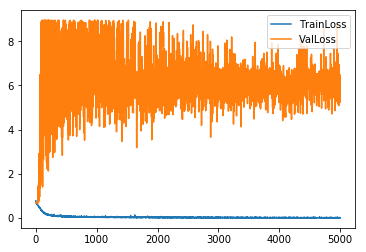

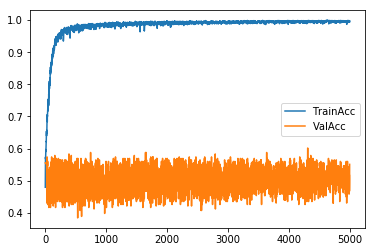

In [45]:
# Visualize the loss and accuracy.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['TrainLoss', 'ValLoss'])
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['TrainAcc', 'ValAcc'])
plt.show()

In [46]:
model.metrics_names

['loss', 'acc']

In [77]:
# rnn+cnn epochs 500 with all selu activation function
model= load_model('model/rnncnn_5000.hdf5')
model.evaluate(x_test,y_test)

540/540 [==============================] - 0s 373us/step


[0.6822089579370286, 0.5777777782192937]

In [92]:
# lstm rnn only
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

window_size = 15
activation_function = 'sigmoid'
loss_function = 'binary_crossentropy'
optimizer = Adam(lr=0.00005)
metrics = ['accuracy']

if not os.path.exists('model'):
    os.makedirs('model')

filepath="model/rnn_800.hdf5"

model = Sequential()

#First recurrent layer with dropout
model.add(LSTM(window_size, input_shape=(window_size, x_train.shape[-1])))
model.add(Dense(100))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

#Output layer (returns the predicted value)
model.add(Dense(units=1))

#Set activation function
model.add(Activation(activation_function))

#Set loss function and optimizer
model.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)

# if train, turn on.
# history = model.fit(x_train, y_train, epochs=800, batch_size=50, validation_split= 0.1, verbose=0, shuffle=False)

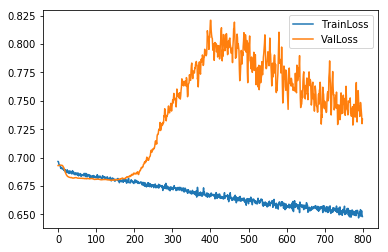

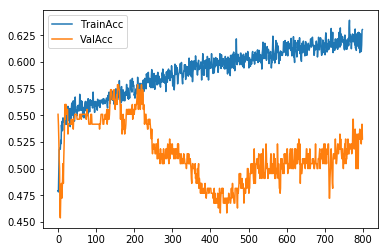

In [93]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['TrainLoss', 'ValLoss'])
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['TrainAcc', 'ValAcc'])
plt.show()

In [78]:
model.metrics_names

['loss', 'acc']

In [94]:
# rnn epochs 500 relu activation function
model= load_model('model/rnn_800.hdf5')
model.evaluate(x_test,y_test)

540/540 [==============================] - 0s 236us/step


[0.798587504139653, 0.5185185180770027]